In [ ]:
!pip install torch
!pip install transformers

In [2]:
import json
import os
import random
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


In [3]:
# 'combined_list' now contains the combined data from all files
file_paths = ["dataset.json"]

dataset = []

for file_path in file_paths:
    with open(file_path, "r") as file:
        data = json.load(file)

random.shuffle(data)
len(data)

47136

In [4]:
dataset = []

for i in range(0, len(data)):
    item = data[i].copy()
    item.pop('judgments', None)
    dataset.append(item)

for i in range(0, len(dataset)):
  dataset[i]['evidences'] = dataset[i]['evidences'][0].get('snippet')

dataset[0]

{'pred': '/people/person/education./education/education/institution',
 'sub': 'Anne Wilson',
 'obj': 'George School',
 'evidences': "Anne Wilson was born in Detroit, Michigan in 1949. At 15, she attended George School, a Quaker boarding school, in Pennsylvania, where she received training in feminist theory and the philosophies of passive resistance through the study of Gandhi's teachings on non-violent politics. In her later research, Wilson remarked that her lessons at George School, especially Gandhi's exhortation to all Indians that they must practice spinning--for social, political, economic and spiritual reasons--profoundly influenced her life and artistic practice."}

In [5]:
map_pred2label ={
    '/people/person/education./education/education/institution': "educated in",
    '/people/deceased_person/place_of_death': "died in",
    '/people/person/place_of_birth': "born in",
    '/people/person/date_of_birth': "born on",
    '/people/person/education./education/education/degree': "has degree"
}

for i in range(0, len(dataset)):
  dataset[i]['pred'] = map_pred2label[dataset[i]['pred']]

dataset[0]

{'pred': 'educated in',
 'sub': 'Anne Wilson',
 'obj': 'George School',
 'evidences': "Anne Wilson was born in Detroit, Michigan in 1949. At 15, she attended George School, a Quaker boarding school, in Pennsylvania, where she received training in feminist theory and the philosophies of passive resistance through the study of Gandhi's teachings on non-violent politics. In her later research, Wilson remarked that her lessons at George School, especially Gandhi's exhortation to all Indians that they must practice spinning--for social, political, economic and spiritual reasons--profoundly influenced her life and artistic practice."}

In [6]:
# Print the attributes
preds = []
for i in range(0,len(dataset)):
  for key, value in dataset[i].items():
    if key == "pred" and value not in preds:
      preds.append(value)

print(preds)


# count the number of data points related to each attribute
pred_counts = Counter(entry['pred'] for entry in dataset)
print(pred_counts)

['educated in', 'born in', 'has degree', 'died in', 'born on']
Counter({'educated in': 31991, 'born in': 8389, 'died in': 2745, 'born on': 2282, 'has degree': 1729})


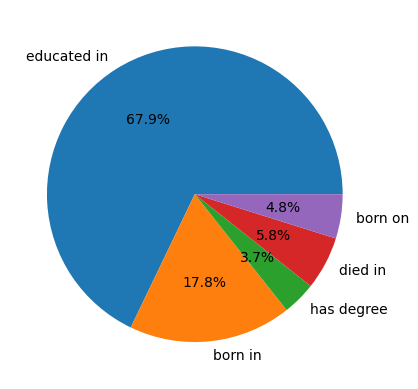

In [7]:
#  plot the pecentage of data points related to each attribute

pie_chart = plt.pie(pred_counts.values(), labels= preds, autopct='%1.1f%%')
plt.show(pie_chart)

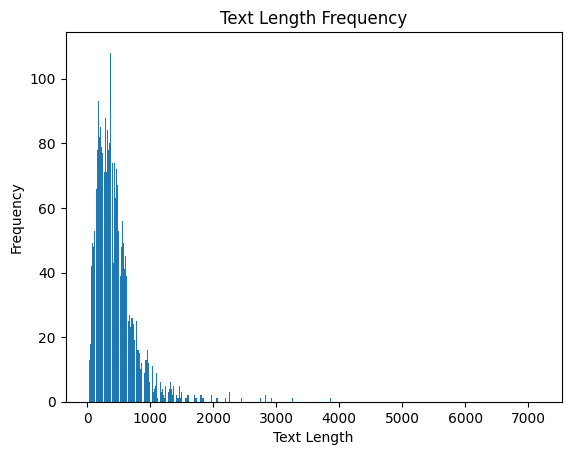

In [8]:
for data in dataset:
  data['text_length'] = len(data['evidences'])

length_frequency = Counter(entry['text_length'] for entry in dataset)

# Extract lengths and frequencies for plotting
lengths = list(length_frequency.keys())
frequencies = list(length_frequency.values())

# Plotting
plt.bar(lengths, frequencies)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Frequency')
plt.show()

In [9]:
# filter the dataset based on the text length
for data in dataset:
  if data['text_length'] > 600:
    dataset.remove(data)

len(dataset)

38172

In [10]:
Counter(data['pred'] for data in dataset)

Counter({'educated in': 25085,
         'born in': 7286,
         'has degree': 1422,
         'died in': 2392,
         'born on': 1987})

In [12]:
sampling_strategy= {'born in': 2200,
                    'educated in':2200,
                    'died in': 2200,
                    'born on': 1987,
                    'has degree':1412
}

X = [list(data.values()) for data in dataset]
y = [data['pred'] for data in dataset]

# Apply UnderSampling
under_sampling = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_undersample, y_undersample = under_sampling.fit_resample(X, y)

# Apply oversampling
over_sampling = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_balanced, y_balanced = over_sampling.fit_resample(X_undersample, y_undersample)

# Check the class distribution after balancing
print(Counter(y_balanced))

Counter({'born in': 2200, 'born on': 2200, 'died in': 2200, 'educated in': 2200, 'has degree': 2200})


In [15]:
degree_type =[]
for x in X_balanced:
  if x[0] == 'has degree':
    degree_type.append(x[2])

degree_count = Counter(degree_type)
degree_count = sorted(degree_count.items(), key=lambda item: item[1], reverse=True)
print(degree_count[0:5])
print(len(degree_count))

[('Bachelor of Arts', 1075), ('Bachelor of Science', 385), ('Bachelor of Laws', 115), ('Bachelor of Fine Arts', 70), ('Master of Arts', 62)]
69


In [ ]:
# Mapping list of degree categories to their corresponding degree abbreviations
degree_mapping = {
    "Bachelor of Laws": "B.L.",
    "Bachelor of Arts": "B.A.",
    "Bachelor of Science": "B.Sc",
    "Bachelor of Fine Arts": "BFA",
    "Bachelor of Philosophy": "Ph.B.",
    "Master of Arts": "M.A.",
    "Doctor of Medicine": "M.D.",
    "Master of Business Administration": "MBA",
    "Juris Doctor": "J.D.",
    "Bachelor of Technology": "B.Tech",
    "Bachelor of Music": "Mus.B.",
    "Bachelor of Engineering": "BSEE",
    "Doctor of Philosophy": "Ph.D",
    "Master of Science": "M.Sc.",
    "Business administration": "B.B.A.",
    "Legum Doctor": "LL.D.",
    "Master of Social Work": "M.S.W.",
    "Bachelor of Theology": "Th.B.",
    "Bachelor of Education": "B.Ed",
    "Doctor of Divinity": "D.D.",
    "Doctor of Education": "Ed.D.",
    "Bachelor of Electrical Engineering": "B.E.E.",
    "Master of Laws": "LL.M."
}


def extract_degree(text, degree_object):
    marked_text = text
    # Find the corresponding degree abbreviation for the given degree object
    degree_abbr = degree_mapping.get(degree_object)
    if degree_abbr:
        # Escape the degree abbreviation
        degree_abbr_escaped = re.escape(degree_abbr)
        # Create a regex pattern for the degree abbreviation
        pattern = r'\b' + degree_abbr_escaped + r'\W'
        # Search for the pattern in the text
        match = re.search(pattern, marked_text)
        # If a match is found, replace the abbreviation with the full degree name in the text
        if match:
            marked_text = re.sub(pattern, f'{degree_object}', marked_text)
    return marked_text


In [ ]:
def extract_year(date):
    # Match year in YYYY-MM-DD format
    year_pattern = r'(\b\d{4}\b)-\d{2}-\d{2}'
    match = re.search(year_pattern, date)
    if match:
        # Extract year and convert to YY format
        full_year = match.group(1)
        return full_year[-4:]
    else:
        return date


In [20]:
def mark_entities(data):

    relation, subject, obj, text, length = data

    if relation == 'has degree':
      text = extract_degree(text, obj)

    if obj == 'born on':
      obj = extract_year(obj)

    # Extract first and last name of the subject
    subject_parts = subject.split()

    # Try to replace the most specific subject mention first
    subject_found = False
    if subject in text:
        text = text.replace(subject, f"[E1]{subject}[/E1]")
        subject_found = True

    else:
      for name in subject_parts:
        if name in text:
          text = text.replace(name, f"[E1]{name}[/E1]")
          subject_found = True

    # Mark the object in the sentence
    if obj in text:
        text = text.replace(obj, f"[E2]{obj}[/E2]")

    text = text.replace('.', '.[SEP]')

    # Split the text into segments using [SEP]
    segments = text.split("[SEP]")

    # Keep only segments that contain [E1] or [E2]
    filtered_segments = [segment.strip() for segment in segments if "[E1]" in segment or "[E2]" in segment]

    # Reconstruct the filtered text
    cleaned_text = " [SEP] ".join(filtered_segments)

    item = [subject, obj, relation, cleaned_text]

    return item


In [21]:
text_list = []
for item in X_balanced:
  text_list.append(mark_entities(item))

text_list[0:2]

[['Joan Backes',
  'Milwaukee',
  'born in',
  "jpg thumb 300px right [E1]Joan Backes[/E1] - Forest-House, 2010, (permanent installation), Darmstadt, Germany. [SEP] Invitational International Biennial `` Internationalen Waldkunstpfad '')) [E1]Joan Backes[/E1] is an American artist who was born in [E2]Milwaukee[/E2], Wisconsin."],
 ['Bert Ruiter',
  'Amsterdam',
  'born in',
  '[E1]Bert Ruiter[/E1] (born 26 November 1946, [E2]Amsterdam[/E2]) is a Dutch bass guitarist, record producer, and composer.']]

In [22]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Define the mapping between labels and encoded numbers
label_mapping = {
    'educated in': 0,
    'died in': 1,
    'born in': 2,
    'born on': 3,
    'has degree': 4
}

# Fit the label encoder with the specified mapping
label_encoder.fit(list(label_mapping.values()))

# Extract the labels from X_balanced
classes = [entry[2] for entry in text_list]

# Transform the labels using the fitted label encoder
encoded_labels = [label_mapping[label] for label in classes]

# Update the labels in X_balanced
for i, entry in enumerate(text_list):
    entry.append(encoded_labels[i])


In [24]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', pad_token= '[PAD]')
from torch.nn.utils.rnn import pad_sequence

# Define a function to pad or truncate sequences
def pad_sequences(seq, max_length):
    if len(seq) < max_length:
        # Pad with [PAD] tokens if the sequence is shorter than max_length
        padding = ['[PAD]'] * (max_length - len(seq))
        return seq + padding
    else:
        # Truncate if the sequence is longer than max_length
        return seq[:max_length]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

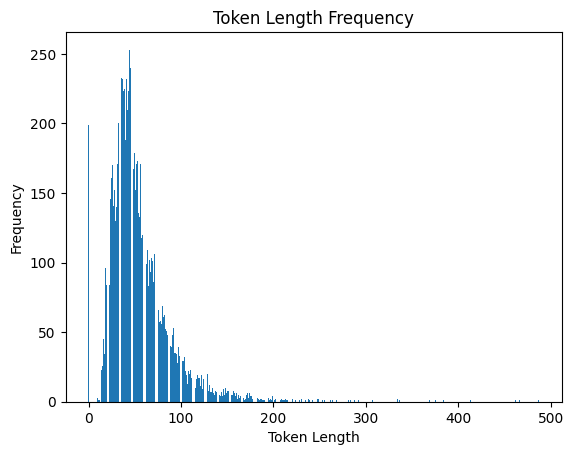

In [25]:
# Initialize lists to store tokenized inputs and labels
token_text= []
token_len = []
# Process each data point in the dataset
for data_point in text_list:
    text = data_point[3]

    # Tokenize the subject, object, and text using BERT tokenizer
    tokenized_text = tokenizer.tokenize(text)
    token_text.append(tokenized_text)
    token_len.append(len(tokenized_text))

# Count the frequency of each text length
token_length_freq = Counter(token_len)

# Extract lengths and frequencies for plotting
lengths = list(token_length_freq.keys())
frequencies = list(token_length_freq.values())

# Plotting
plt.bar(lengths, frequencies)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Frequency')
plt.show()


In [26]:
# Define your max sequence length
max_seq_length = 128

# Initialize lists to store tokenized inputs and labels
inputs_text = []
labels = []

# Process each data point in the dataset
for data_point in text_list:
    text = data_point[3]

    tokenized_text = tokenizer.tokenize(text)
    tokenized_text = tokenized_text[:max_seq_length - 2]
    tokenized_text = ['[CLS]'] + tokenized_text + ['[SEP]']
    paded_text = pad_sequences(tokenized_text, max_seq_length)

    # Convert the tokenized subject, object, and text to input IDs
    input_ids_text = tokenizer.convert_tokens_to_ids(paded_text)
    inputs_text.append(input_ids_text)

    # Label the relevant entities and their relationships
    relation_label = data_point[4]
    label = relation_label
    labels.append(label)


In [27]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
train_input, val_input, train_labels, val_labels = train_test_split(inputs_text, labels, test_size=0.3,stratify= labels ,random_state=42)
val_input, test_input, val_labels, test_labels = train_test_split(val_input, val_labels, test_size=0.5, random_state=42)


In [28]:
train_input_tns = torch.tensor(train_input)
train_labels_tns = torch.tensor(train_labels)

val_input_tns = torch.tensor(val_input)
val_labels_tns = torch.tensor(val_labels)

test_input_tns = torch.tensor(test_input)
test_labels_tns = torch.tensor(test_labels)

In [29]:
# Create a TensorDataset from the input tensors and labels
train_dataset = TensorDataset(train_input_tns, train_labels_tns)

val_dataset = TensorDataset(val_input_tns, val_labels_tns)

test_dataset = TensorDataset(test_input_tns, test_labels_tns)

# Define batch size and create DataLoader instances
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [43]:
# Define the BERT model architecture
# Load pre-trained BERT model and add a classification layer on top
from transformers import AutoTokenizer, DistilBertForSequenceClassification
model_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Optional: Freeze BERT layers if desired
for param in model_bert.base_model.parameters():
    param.requires_grad = False

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Wrap the model with DataParallel
if torch.cuda.device_count() > 1:
    model_bert = torch.nn.DataParallel(model_bert)

# print(model_bert)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Step 5: Fine-tune the BERT model

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model_bert.parameters(), lr=3e-5)
num_epochs = 50
scaler = GradScaler()

# Create an array to save train loss (will be used in the plot)
train_loss_array = []

# Training loop
for epoch in range(num_epochs):
    model_bert.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model_bert(inputs_text, labels= labels)
            logits = outputs.logits

            # Use the Focal Loss function here
            loss = loss_fn(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = total_loss / len(train_dataloader)

    # Validation loop
    model_bert.eval()
    val_loss = 0
    num_val_steps = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs_text,  labels = batch
            inputs_text, labels = inputs_text.to(device), labels.to(device)

            outputs = model_bert(inputs_text)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            num_val_steps += 1

    avg_val_loss = val_loss / num_val_steps

    if epoch % 5 ==0:
      print(f"Epoch {epoch}/{num_epochs}, Train_Loss: {avg_train_loss:.4f}, Val_Loss: {avg_val_loss:.4f}")

    train_loss_array.append(avg_train_loss)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-44-9f0e9260eb3b>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-44-9f0e9260eb3b>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 0/50, Train_Loss: 1.5401, Val_Loss: 1.4381
Epoch 5/50, Train_Loss: 0.9784, Val_Loss: 0.8968
Epoch 10/50, Train_Loss: 0.8097, Val_Loss: 0.7483
Epoch 15/50, Train_Loss: 0.7320, Val_Loss: 0.6825
Epoch 20/50, Train_Loss: 0.6884, Val_Loss: 0.6450
Epoch 25/50, Train_Loss: 0.6578, Val_Loss: 0.6192
Epoch 30/50, Train_Loss: 0.6384, Val_Loss: 0.6014
Epoch 35/50, Train_Loss: 0.6131, Val_Loss: 0.5857
Epoch 40/50, Train_Loss: 0.5983, Val_Loss: 0.5724
Epoch 45/50, Train_Loss: 0.5906, Val_Loss: 0.5629


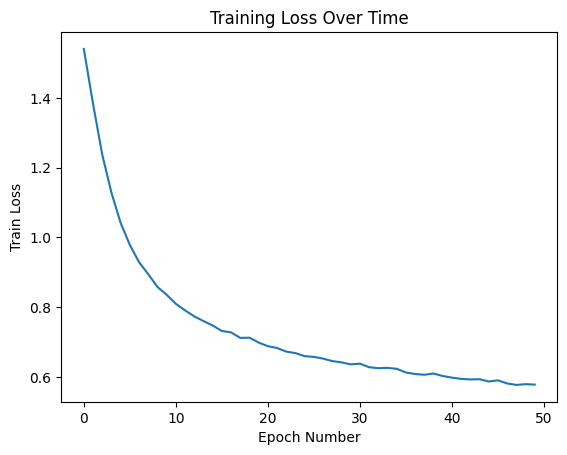

In [45]:

# Create the plot
plt.plot(train_loss_array)
# Adding a title
plt.title('Training Loss Over Time')

# Adding labels for the x and y axes
plt.xlabel('Epoch Number')
plt.ylabel('Train Loss')

plt.show()


In [46]:
def compute_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    correct_predictions = torch.eq(predicted_labels, labels).sum().item()
    accuracy = correct_predictions / len(labels)
    return accuracy



In [47]:
# evaluate the model by computing  accuracy, precision, recall, and F1-score
model_bert.eval()
val_accuracy = 0
num_val_steps = 0

with torch.no_grad():
    for batch in val_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = model_bert(inputs_text)
        val_accuracy += compute_accuracy(outputs.logits, labels)
        num_val_steps += 1

avg_val_accuracy = val_accuracy / num_val_steps

print(f"Validation Accuracy: {avg_val_accuracy:.4f}")


Validation Accuracy: 0.7879


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluation loop
model_bert.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs_text, labels = batch
        inputs_text, labels = inputs_text.to(device), labels.to(device)

        outputs = model_bert(inputs_text)
        predicted_labels = torch.argmax(outputs.logits, dim=1)

        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())


In [49]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.76      0.73      0.75       368
           1       0.93      0.91      0.92       318
           2       0.72      0.63      0.67       307
           3       0.70      0.82      0.75       347
           4       0.91      0.91      0.91       310

    accuracy                           0.80      1650
   macro avg       0.80      0.80      0.80      1650
weighted avg       0.80      0.80      0.80      1650



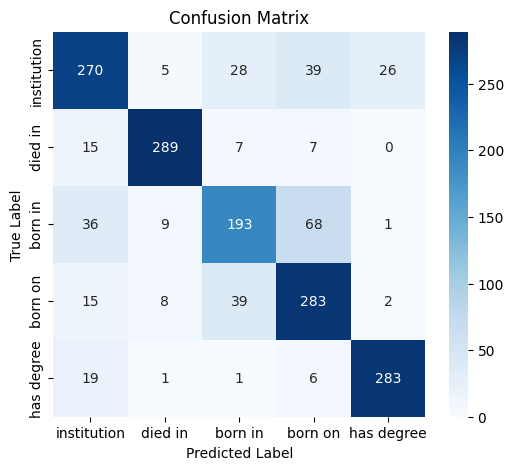

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['institution', 'died in', 'born in', 'born on', 'has degree'], yticklabels=['institution', 'died in', 'born in', 'born on', 'has degree'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [52]:
import numpy as np

print("True Label Distribution:")
print(np.bincount(true_labels))

print("Predicted Label Distribution:")
print(np.bincount(predictions))


True Label Distribution:
[368 318 307 347 310]
Predicted Label Distribution:
[355 312 268 403 312]
